In [160]:
lapply(strsplit('tidyverse lubridate zoo ggpubr cmdstanr', split = ' ')[[1]],
       \(x) c(x, require(x, character.only = TRUE, quietly = TRUE)))
fig = \(width, height) options(repr.plot.width=width, repr.plot.height=height)

[[1]]
[1] "tidyverse" "TRUE"     

[[2]]
[1] "lubridate" "TRUE"     

[[3]]
[1] "zoo"  "TRUE"

[[4]]
[1] "ggpubr" "TRUE"  

[[5]]
[1] "cmdstanr" "TRUE"

s -> p1 -> p2

$
\def\d{\,{\rm d}}
\begin{align}
h(p|s) = \int g(p|u) b(u|s) \d u
\end{align}$

$\begin{align}
& W(p) P(p) f_p(s-p) = S(s) b_s(p-s)\\
\Longrightarrow & b(-\tau) \sim \exp(-r\tau) f(\tau) & s-p=\tau,\ P(t) = P(0)\exp(rt),\ W(p) = 1,\ f_p(\tau) = f(\tau) \\
\end{align}$

In [ ]:
uk.pop = 67.22e6
lc = 1.1e6 # total # of long covid as of 5 Sep 2021
lc.12w = 831e3 # had C19 at least 12 weeks previously
lc.year = 405e3 # at least one year
lc.aff = 706e3 # adversely affected by
lc.sev = 211e3 # severely affected

In [1]:
1.1 / 67.22

[1] 0.01636418

In [182]:
cases = read_csv('https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&metric=newCasesBySpecimenDateAgeDemographics&format=csv')
deaths = read_csv('https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&metric=newDeaths28DaysByDeathDateAgeDemographics&format=csv')
hosp = read_csv('https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&metric=cumAdmissionsByAge&format=csv')

Rows: 15510 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): areaCode, areaName, areaType, age
dbl  (3): cases, rollingSum, rollingRate
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 14133 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): areaCode, areaName, areaType, age
dbl  (3): deaths, rollingSum, rollingRate
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3295 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): areaCode, areaName, areaType, age
dbl  (2): rate, value
date (1): date


ℹ Use `spec()` to retrieve the full column 

In [230]:
hosp %>%
    group_by(age) %>%
    complete(date = full_seq(date, period = 1)) %>%
    arrange(date) %>%
    mutate(value = value %>% na.locf %>% { . - lag(.,1) }) %>%
    ungroup() -> hosp

In [259]:
cases$age %>% unique %>% str_sort(numeric = TRUE)

[1] "00_04"      "00_59"      "05_09"      "10_14"      "15_19"     
 [6] "20_24"      "25_29"      "30_34"      "35_39"      "40_44"     
[11] "45_49"      "50_54"      "55_59"      "60_64"      "60+"       
[16] "65_69"      "70_74"      "75_79"      "80_84"      "85_89"     
[21] "90+"        "unassigned"

In [260]:
deaths$age %>% unique %>% str_sort(numeric = TRUE)

[1] "00_04" "00_59" "05_09" "10_14" "15_19" "20_24" "25_29" "30_34" "35_39"
[10] "40_44" "45_49" "50_54" "55_59" "60_64" "60+"   "65_69" "70_74" "75_79"
[19] "80_84" "85_89" "90+"

In [261]:
hosp$age %>% unique %>% str_sort(numeric = TRUE)

[1] "0_to_5"   "6_to_17"  "18_to_64" "65_to_84" "85+"

In [297]:
cases %>%
    select(areaName, date, cases, age) %>%    
    pivot_wider(names_from = age, values_from = cases) %>%
    transmute(
        areaName, date,
        `0_to_4` = `00_04`,
        `5_to_19` = `05_09` + `10_14` + `15_19`,
        `20_to_64` = `00_59` + `60_64` - `0_to_4` - `5_to_19`,
        `65_to_84` = `65_69` + `70_74` + `75_79` + `80_84`,
        `85+` = `85_89` + `90+` 
    ) %>%
    pivot_longer(-c(areaName, date)) %>%
    mutate(name = factor(name, levels = str_sort(numeric = TRUE, unique(name)))) %>%
    group_by(name) %>%
    complete(date = full_seq(date, period = 1), fill = list(value = 0)) %>%
    mutate(value = rollmean(value, k = 7, na.pad = TRUE)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    scale_y_log10(limits = c(1,NA)) -> g.case

In [295]:
hosp %>%
    mutate(age = factor(age, levels = age %>% unique() %>% str_sort(numeric = TRUE))) %>%
    group_by(age) %>%
    arrange(date) %>%
    mutate(value = rollmean(value, k = 7, na.pad = TRUE)) %>%    
ggplot() +
    geom_line(aes(date, value, color=age)) + 
    scale_y_log10(limits = c(1, NA)) -> g.hosp

In [315]:
deaths %>%
    select(areaName, date, deaths, age) %>%
    pivot_wider(names_from = age, values_from = deaths) %>%
    transmute(
        areaName, date,
        `0_to_4` = `00_04`,
        `5_to_19` = `05_09` + `10_14` + `15_19`,
        `20_to_64` = `00_59` + `60_64` - `0_to_4` - `5_to_19`,
        `65_to_84` = `65_69` + `70_74` + `75_79` + `80_84`,
        `85+` = `85_89` + `90+` 
    ) %>%
    pivot_longer(-c(areaName, date)) %>%
    mutate(name = factor(name, levels = str_sort(numeric = TRUE, unique(name)))) %>%
    group_by(name) %>%
    complete(date = full_seq(date, period = 1), fill = list(value = 0)) %>%
    mutate(value = rollmean(value, k = 7, na.pad = TRUE)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    scale_y_log10(limits = c(1,NA)) -> g.death

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1700 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1455 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1596 row(s) containing missing values (geom_path).”


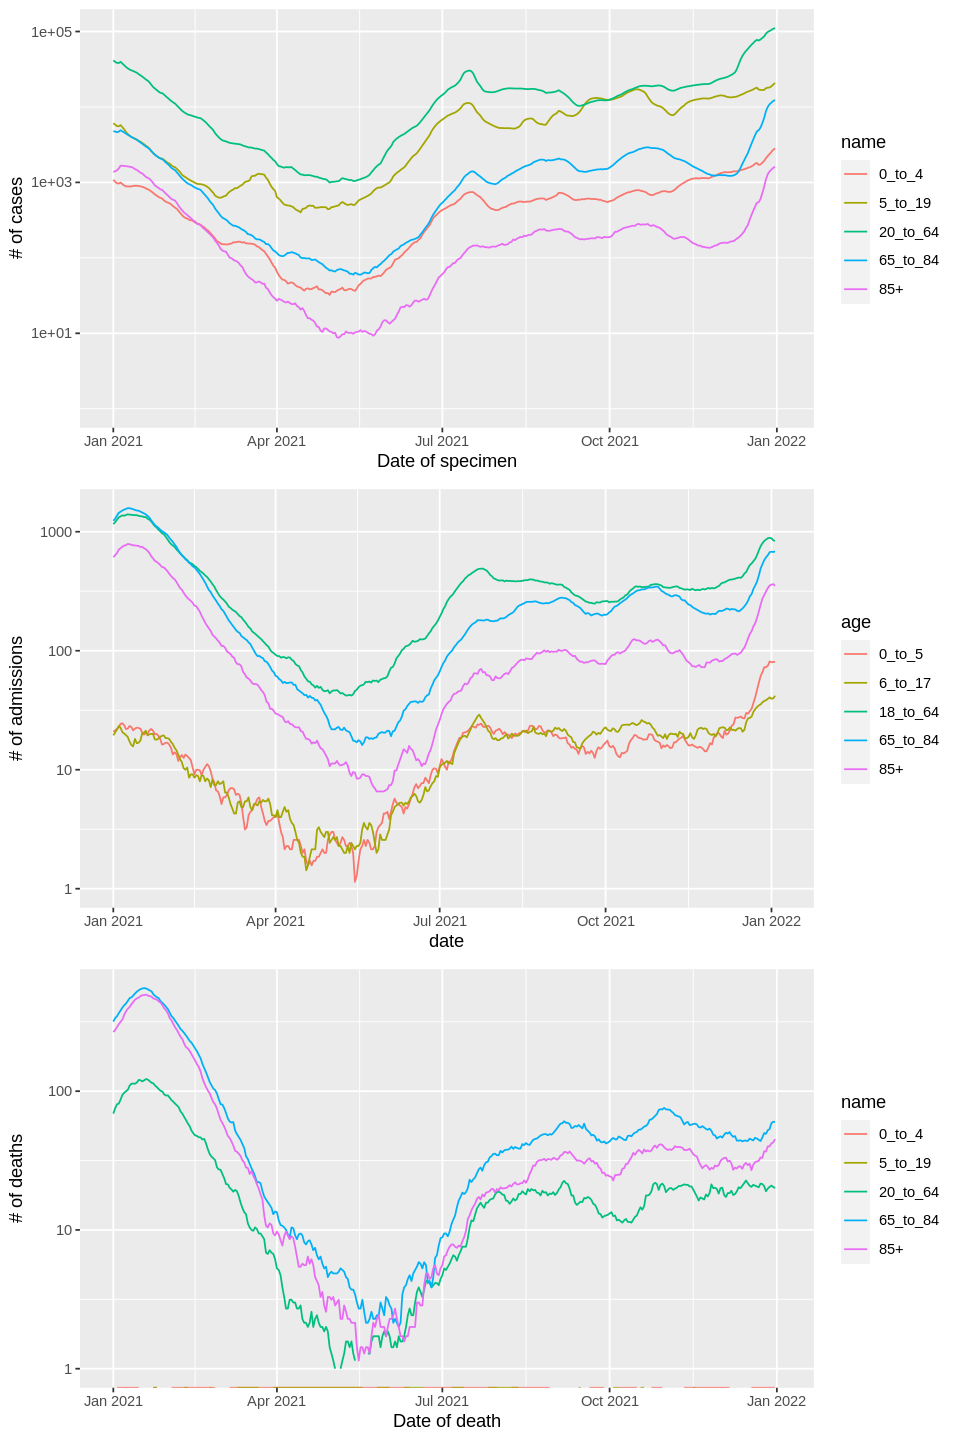

In [318]:
g.setup = \(g) g +
    scale_x_date(limits = ymd(c('2021/1/1', NA)))
ggarrange(
    g.setup(g.case) + labs(y = '# of cases', x = 'Date of specimen'),
    g.setup(g.hosp) + labs(y = '# of admissions'),
    g.setup(g.death) + labs(y = '# of deaths', x = 'Date of death'),
    ncol = 1,
    align = 'v') -> g

fig(8,12)
g

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


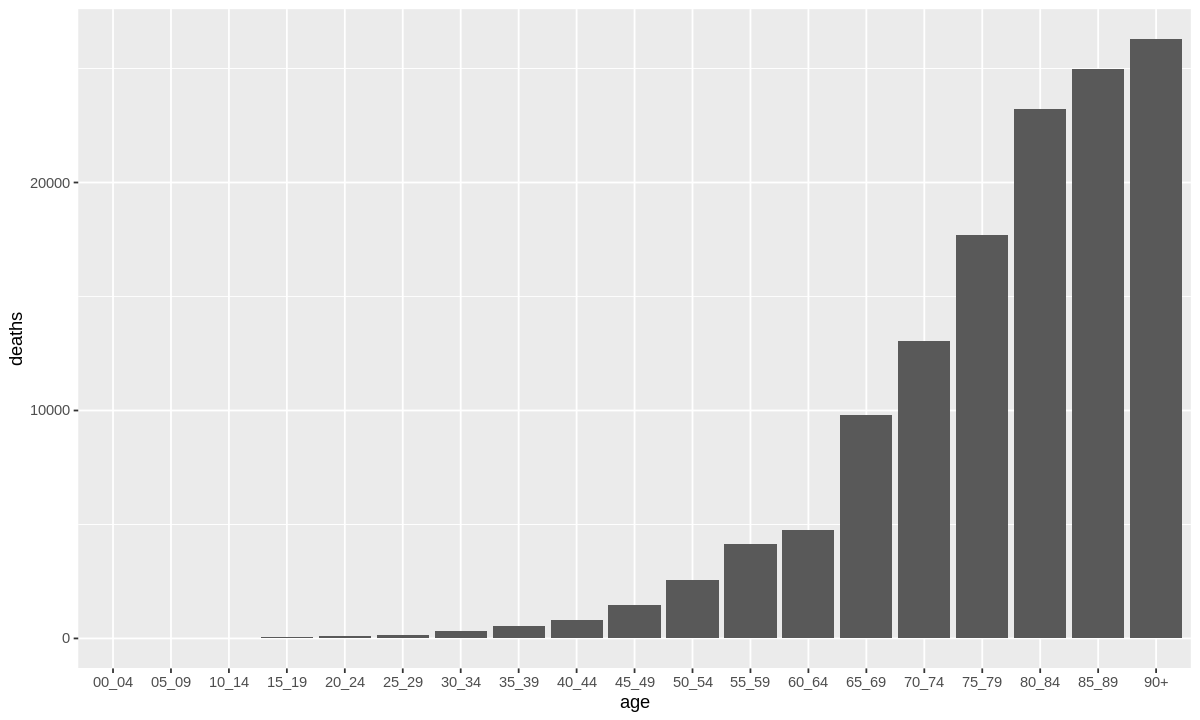

In [337]:
deaths %>%
    group_by(age) %>%
    summarize(deaths = sum(deaths)) %>%
    ungroup() %>%
    filter(!(age %in% c('00_59', '60+'))) %>%
    mutate(age = factor(age, levels = str_sort(numeric = TRUE, unique(age)))) %>%
ggplot() +
    geom_histogram(aes(age, deaths), stat = 'identity') -> g

fig(10,6)
g

In [82]:
case %>%
    filter(areaName == 'England' & age == '00_59') %>%
    complete(date = full_seq(date, period = 1)) %>%
    mutate(cases = replace_na(cases, 0)) %>%
    group_by(id=strftime(date, format='%Y%m')) %>%
    mutate(id = cur_group_id()) %>%
    ungroup() -> t

$$
\def\d{\,{\rm d}}
\def\R{{\cal R}}
\begin{align}
j_1(p) &= \int_p^\infty c_1(q) b_q(p-q) \d q \\
j_2(r) &= \R(r) \int_{-\infty}^r j_1(p) g(r-p) \d p \\
c_2(s) &= \int_{-\infty}^s j_2(r) f(s-r) \d r \\
\end{align}
$$

$$W(p) P(p) f_p(\tau) = S(s) b_s(-\tau)$$
where $s-p=\tau$.

$$
j_1(p) f_p(q-p) = c_1(q) b_q(p-q)
$$

$$
j_1(q) \exp\left(- \int_p^q r(t) \d t\right) f(q-p) = c_1(q) b_q(p-q)
$$

$$
b_q(p-q) \sim \exp\left(-\int_p^q r(t) \d t\right) f(q-p)
$$

In [171]:
300e4/6600/147e3 * 300

[1] 0.9276438

In [58]:
model = cmdstan_model(write_stan_file('
data {
    int N;
    vector<lower=0>[N] j;
    int K;
    array[N] int<lower=1,upper=K> kk;
}

transformed data {
    real EPS = 1e-12;
}

parameters {
    // real<lower=EPS> j0;
    vector<lower=-10, upper=10>[K] r;
}

transformed parameters {
    vector[N] _r;
    for(t in 1:N) _r[t] = r[kk[t]];
    // vector[N] _j = j0 * exp(cumulative_sum(_r));
}

model {
    // target += gamma_lpdf(_j + EPS | j + 1, 1);
    target += gamma_lpdf((j .* exp(_r))[1:(N-1)] + EPS | j[2:N] + 1, 1);
}
'))

In [113]:
fit = model$sample(refresh = 0,
    chains = 4, parallel_chains = 4, iter_warmup = 1000, iter_sampling = 1000, 
    data = list(
        N = nrow(t),
        j = t$cases,
        K = max(t$id),
        kk = t$id
    )        
)

Running MCMC with 4 parallel chains...

Chain 3 finished in 12.6 seconds.
Chain 2 finished in 14.4 seconds.
Chain 4 finished in 14.3 seconds.
Chain 1 finished in 27.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 17.3 seconds.
Total execution time: 27.9 seconds.


Warning message:
“Transformation introduced infinite values in continuous y-axis”


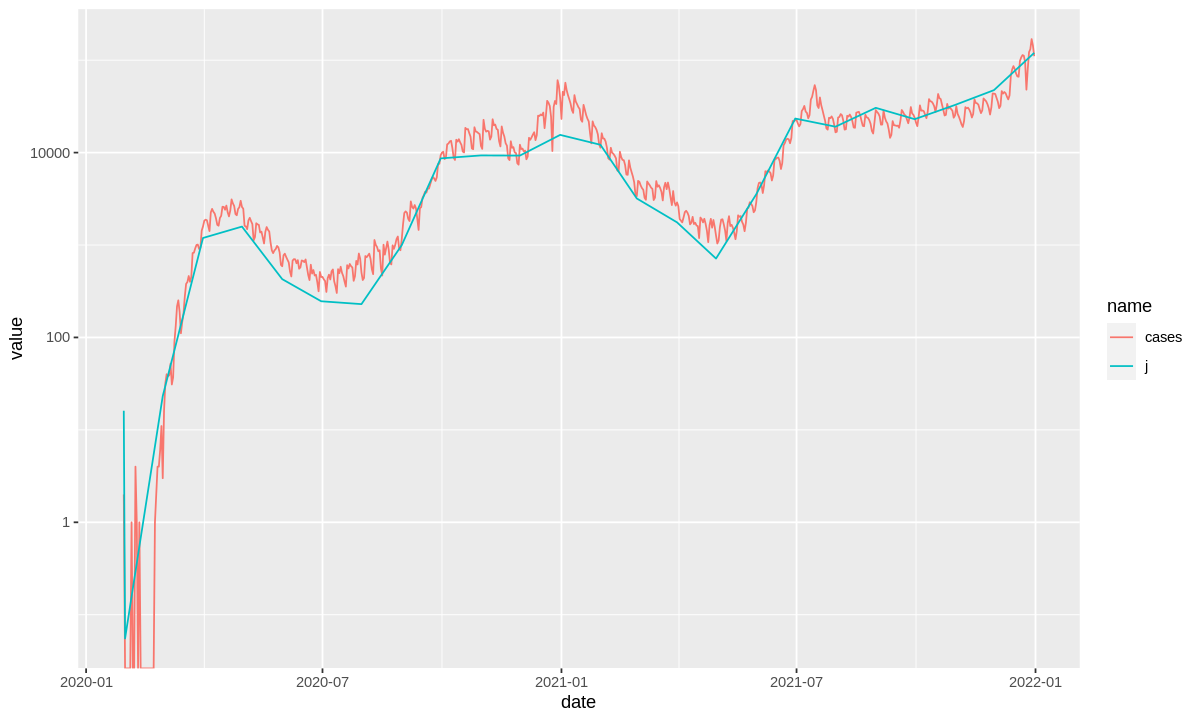

In [114]:
r = fit$summary('_r', 'mean')$mean
j0 = optim(1, \(j0) with(t, sum((cases - j0*exp(cumsum(r)))^2)), method='L-BFGS-B')$par
t %>%
    mutate(
        j = j0 * exp(cumsum(r))
    ) %>%
    pivot_longer(c(cases, j)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) -> g

fig(10,6)
g + scale_y_log10()

In [117]:
case = read_csv('../data/uk/nation_cases_by_age.csv')
death = read_csv('../data/uk/nation_deaths_by_age.csv')

full_join(
    case %>% transmute(areaName, date, age, cases),
    death %>% transmute(areaName, date, age, deaths),
    by = c('areaName', 'date', 'age')
) -> uk

Rows: 15444 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): areaCode, areaName, areaType, age
dbl  (3): cases, rollingSum, rollingRate
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 14070 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): areaCode, areaName, areaType, age
dbl  (3): deaths, rollingSum, rollingRate
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [118]:
uk$age %>% unique %>% paste(sep = ',')

[1] "00_04"      "00_59"      "05_09"      "10_14"      "15_19"     
 [6] "20_24"      "25_29"      "30_34"      "35_39"      "40_44"     
[11] "45_49"      "50_54"      "55_59"      "60+"        "60_64"     
[16] "65_69"      "70_74"      "75_79"      "80_84"      "85_89"     
[21] "90+"        "unassigned"

Warning message:
“Removed 75 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 58 row(s) containing missing values (geom_path).”


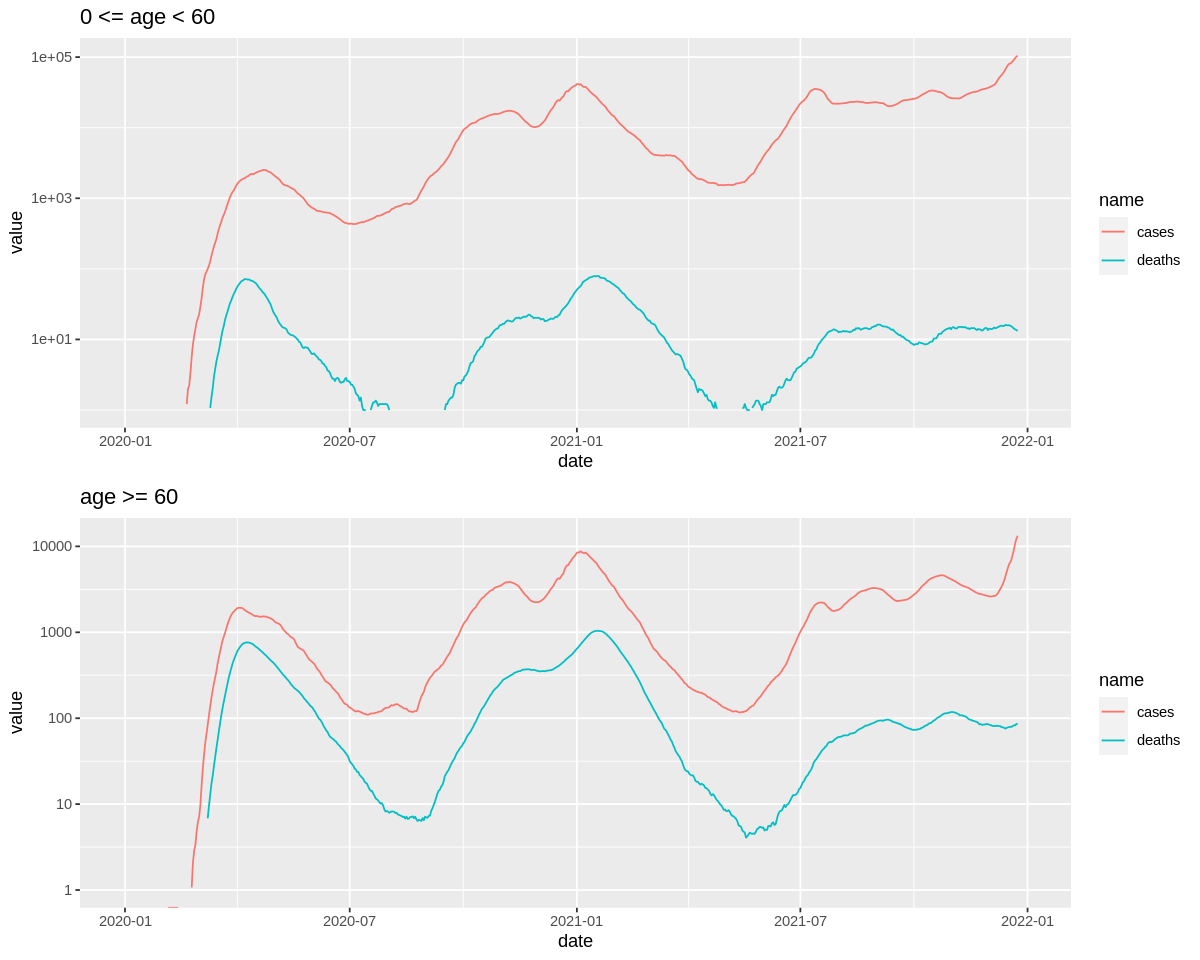

In [119]:
uk %>%
    filter(age == '00_59') %>%
    pivot_longer(c(cases, deaths)) %>%
    group_by(name) %>%
    arrange(date) %>%
    mutate(value = rollmean(value, k=14, na.pad = TRUE)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    labs(title = '0 <= age < 60') -> g_young    

uk %>%
    filter(age == '60+') %>%
    pivot_longer(c(cases, deaths)) %>%
    group_by(name) %>%
    arrange(date) %>%
    mutate(value = rollmean(value, k=14, na.pad = TRUE)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    labs(title = 'age >= 60') -> g_elder

from = ymd('2020/1/1')
g_format = \(g) g +
    scale_x_date(limits=c(from, NA)) +
    scale_y_log10(limits=c(1,NA))

ggarrange(ncol = 1, align = 'v',
    g_format(g_young),
    g_format(g_elder)        
) -> g

fig(10,8)
g

In [125]:
index = read_csv('../data/google/index.csv')

Rows: 22958 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): location_key, place_id, wikidata_id, datacommons_id, country_code,...
dbl  (1): aggregation_level


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [120]:
vax = read_csv('../data/google/vaccinations.csv')

Rows: 1346153 Columns: 32

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): location_key
dbl  (26): new_persons_vaccinated, cumulative_persons_vaccinated, new_person...
lgl   (4): new_persons_fully_vaccinated_sinovac, total_persons_fully_vaccina...
date  (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [128]:
left_join(vax, index, by = 'location_key') %>%
    filter(aggregation_level == 0) -> vax.country

In [147]:
vax = read_csv('../data/covid-vaccine-booster-doses-per-capita.csv')

Rows: 12936 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Entity, Code
dbl  (1): total_boosters_per_hundred
date (1): Day


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [152]:
vax$Entity %>% unique

[1] "Africa"                 "Albania"                "Algeria"               
  [4] "Andorra"                "Anguilla"               "Argentina"             
  [7] "Armenia"                "Asia"                   "Australia"             
 [10] "Austria"                "Azerbaijan"             "Bahamas"               
 [13] "Bahrain"                "Belarus"                "Belgium"               
 [16] "Bermuda"                "Bolivia"                "Bosnia and Herzegovina"
 [19] "Brazil"                 "Bulgaria"               "Cambodia"              
 [22] "Canada"                 "Chile"                  "China"                 
 [25] "Colombia"               "Costa Rica"             "Cuba"                  
 [28] "Curacao"                "Cyprus"                 "Czechia"               
 [31] "Denmark"                "Dominican Republic"     "Ecuador"               
 [34] "El Salvador"            "England"                "Europe"                
 [37] "European Union"         "Faeroe Islands"         "Finland"               
 [40] "France"                 "Germany"                "Gibraltar"             
 [43] "Greece"                 "Guatemala"              "Guyana"                
 [46] "High income"            "Honduras"               "Hong Kong"             
 [49] "Hungary"                "Iceland"                "Iran"                  
 [52] "Ireland"                "Isle of Man"            "Israel"                
 [55] "Italy"                  "Jamaica"                "Japan"                 
 [58] "Kenya"                  "Kuwait"                 "Latvia"                
 [61] "Lebanon"                "Liechtenstein"          "Lithuania"             
 [64] "Lower middle income"    "Luxembourg"             "Malaysia"              
 [67] "Maldives"               "Malta"                  "Mongolia"              
 [70] "Montenegro"             "Netherlands"            "New Zealand"           
 [73] "North America"          "North Macedonia"        "Northern Cyprus"       
 [76] "Northern Ireland"       "Norway"                 "Oceania"               
 [79] "Oman"                   "Palestine"              "Panama"                
 [82] "Paraguay"               "Peru"                   "Philippines"           
 [85] "Poland"                 "Portugal"               "Russia"                
 [88] "Saint Kitts and Nevis"  "Saudi Arabia"           "Scotland"              
 [91] "Serbia"                 "Singapore"              "Slovakia"              
 [94] "Slovenia"               "South America"          "South Korea"           
 [97] "Spain"                  "Sri Lanka"              "Sweden"                
[100] "Switzerland"            "Taiwan"                 "Thailand"              
[103] "Trinidad and Tobago"    "Tunisia"                "Turkey"                
[106] "United Arab Emirates"   "United Kingdom"         "United States"         
[109] "Upper middle income"    "Uruguay"                "Wales"                 
[112] "World"                  "World excl. China"

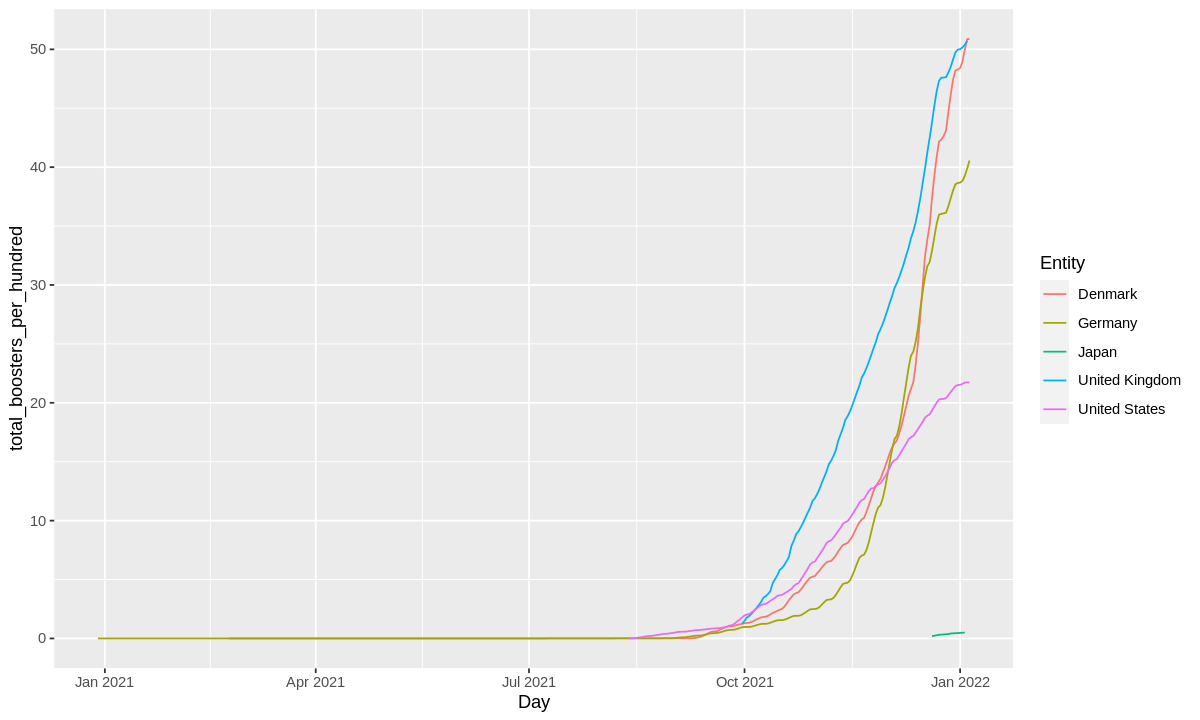

In [159]:
vax %>%
    filter(Entity %in% c('Japan', 'Denmark', 'United Kingdom', 'United States', 'Germany')) %>%
ggplot() +
    geom_line(aes(Day, total_boosters_per_hundred, color=Entity))

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


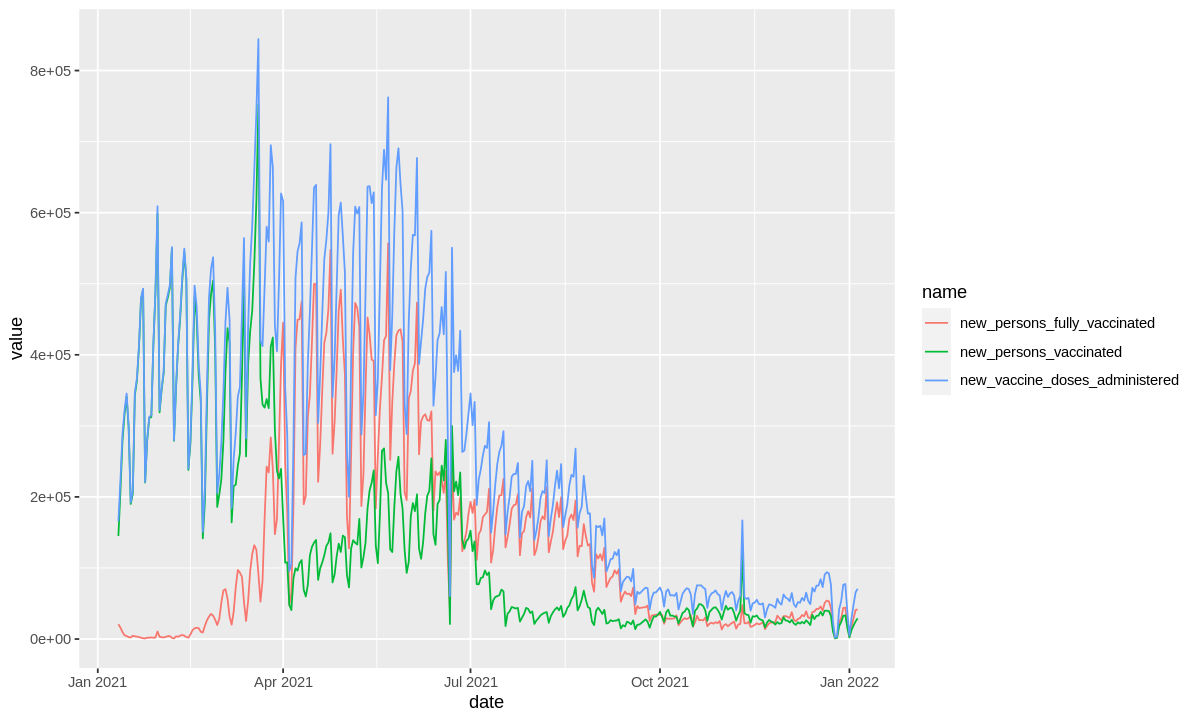

In [146]:
vax.country %>%
    filter(location_key == 'GB') %>%
    select(date,
           new_persons_vaccinated, new_persons_fully_vaccinated,
           new_vaccine_doses_administered) %>%
    pivot_longer(-date) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) -> g

fig(10,6)
g

In [141]:
index %>% filter(str_detect(country_name, 'United') & aggregation_level == 0)

location_key,place_id,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
AE,ChIJvRKrsd9IXj4RpwoIwFYv0zM,Q878,country/ARE,AE,United Arab Emirates,NA,NA,NA,NA,NA,NA,AE,ARE,0
GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,Q145,country/GBR,GB,United Kingdom,NA,NA,NA,NA,NA,NA,GB,GBR,0
UM,ChIJBQ-2twOlemQREDZxw68t4QQ,Q16645,country/UMI,UM,United States Minor Outlying Islands,NA,NA,NA,NA,NA,NA,UM,UMI,0
US,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,NA,NA,NA,NA,NA,NA,US,USA,0
VI,NA,Q11703,country/VIR,VI,United States Virgin Islands,NA,NA,NA,NA,NA,NA,VI,VIR,0


In [130]:
colnames(vax.country)

[1] "date"                                         
 [2] "location_key"                                 
 [3] "new_persons_vaccinated"                       
 [4] "cumulative_persons_vaccinated"                
 [5] "new_persons_fully_vaccinated"                 
 [6] "cumulative_persons_fully_vaccinated"          
 [7] "new_vaccine_doses_administered"               
 [8] "cumulative_vaccine_doses_administered"        
 [9] "new_persons_vaccinated_pfizer"                
[10] "cumulative_persons_vaccinated_pfizer"         
[11] "new_persons_fully_vaccinated_pfizer"          
[12] "cumulative_persons_fully_vaccinated_pfizer"   
[13] "new_vaccine_doses_administered_pfizer"        
[14] "cumulative_vaccine_doses_administered_pfizer" 
[15] "new_persons_vaccinated_moderna"               
[16] "cumulative_persons_vaccinated_moderna"        
[17] "new_persons_fully_vaccinated_moderna"         
[18] "cumulative_persons_fully_vaccinated_moderna"  
[19] "new_vaccine_doses_administered_moderna"       
[20] "cumulative_vaccine_doses_administered_moderna"
[21] "new_persons_vaccinated_janssen"               
[22] "cumulative_persons_vaccinated_janssen"        
[23] "new_persons_fully_vaccinated_janssen"         
[24] "cumulative_persons_fully_vaccinated_janssen"  
[25] "new_vaccine_doses_administered_janssen"       
[26] "cumulative_vaccine_doses_administered_janssen"
[27] "new_persons_vaccinated_sinovac"               
[28] "total_persons_vaccinated_sinovac"             
[29] "new_persons_fully_vaccinated_sinovac"         
[30] "total_persons_fully_vaccinated_sinovac"       
[31] "new_vaccine_doses_administered_sinovac"       
[32] "total_vaccine_doses_administered_sinovac"     
[33] "place_id"                                     
[34] "wikidata_id"                                  
[35] "datacommons_id"                               
[36] "country_code"                                 
[37] "country_name"                                 
[38] "subregion1_code"                              
[39] "subregion1_name"                              
[40] "subregion2_code"                              
[41] "subregion2_name"                              
[42] "locality_code"                                
[43] "locality_name"                                
[44] "iso_3166_1_alpha_2"                           
[45] "iso_3166_1_alpha_3"                           
[46] "aggregation_level"

In [147]:
reduc = read_csv('../data/ReductionRate.csv')

Rows: 28858 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): dataName
dbl  (4): comparisonPreDay, comparisonPreDeclare, comparisonPreSpread, dataType
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [157]:
reduc$dataName %>% unique

[1] "北海道札幌駅周辺"             "青森県青森駅周辺"            
 [3] "岩手県盛岡駅北周辺"           "宮城県仙台駅西周辺"          
 [5] "秋田県秋田駅周辺"             "山形県山形駅周辺"            
 [7] "福島県福島駅周辺"             "茨城県水戸駅周辺"            
 [9] "栃木県宇都宮駅周辺"           "群馬県高崎駅西周辺"          
[11] "埼玉県大宮駅西周辺"           "千葉県千葉駅周辺"            
[13] "東京都新宿駅周辺"             "神奈川県横浜駅周辺"          
[15] "新潟県新潟駅周辺"             "富山県富山駅周辺"            
[17] "石川県金沢駅周辺"             "福井県福井駅周辺"            
[19] "山梨県甲府駅南周辺"           "長野県長野駅周辺"            
[21] "岐阜県岐阜駅周辺"             "静岡県静岡駅周辺"            
[23] "愛知県名古屋駅周辺"           "三重県津駅周辺"              
[25] "滋賀県草津駅西口周辺"         "京都府京都駅周辺"            
[27] "大阪府梅田周辺"               "兵庫県三ノ宮駅周辺"          
[29] "奈良県近鉄奈良駅周辺"         "和歌山県和歌山駅周辺"        
[31] "鳥取県晩稲周辺"               "島根県松江駅周辺"            
[33] "岡山県岡山駅周辺"             "広島県広島駅周辺"            
[35] "山口県下関駅周辺"             "徳島県徳島駅周辺"            
[37] "香川県高松市フェリー通り周辺" "愛媛県松山市駅東側周辺"      
[39] "高知県はりまや橋周辺"         "福岡県天神周辺"              
[41] "佐賀県佐賀駅周辺"             "長崎県長崎駅周辺"            
[43] "熊本県通町筋周辺"             "大分県大分駅付近周辺"        
[45] "宮崎県新別府町周辺"           "鹿児島県天文館周辺"          
[47] "沖縄県県庁前周辺"

j(t+1) = j(t) exp(r(t))
R(t) = (1+r(t) th(t))^k(t)
R(t) = R(0) S(t)^lam(t) M(t)
lam(t) = 1+(1+chi(t)) eta(t)
eta(t) ~ mobility(t) # eta(t) is variance of social activity.
M(t) ~ mobility(t)

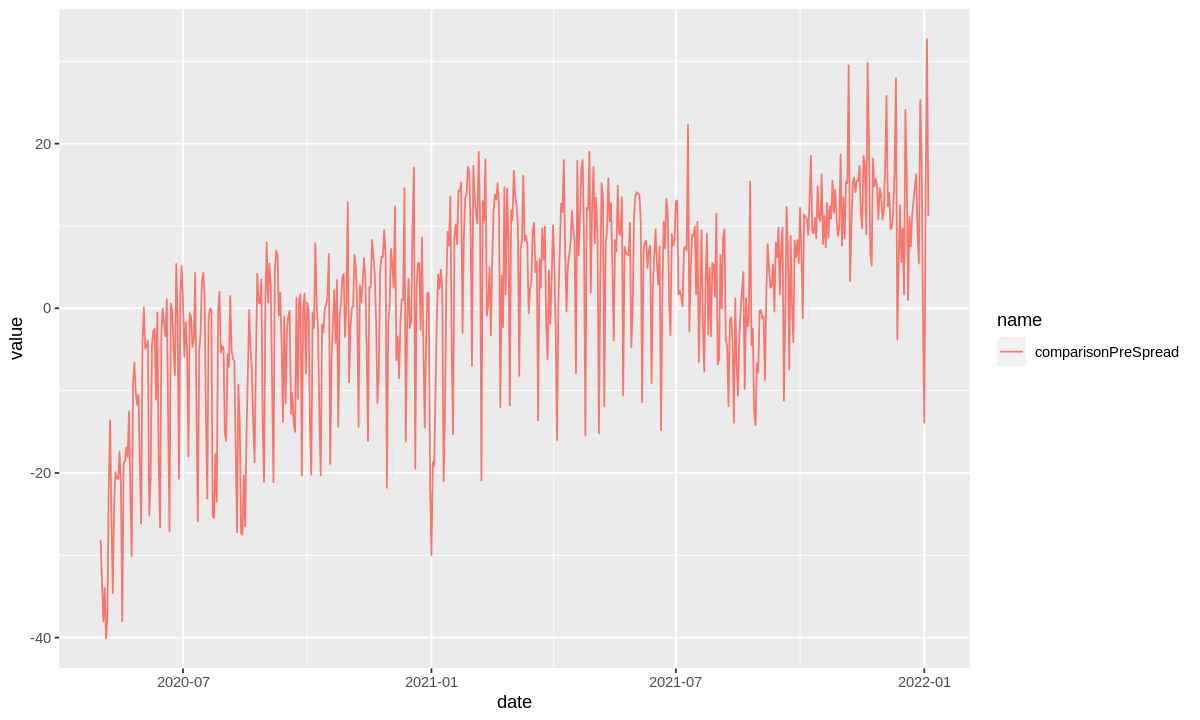

In [170]:
reduc %>%
    filter(startsWith(dataName, '山梨県')) %>%
    select(date, comparisonPreSpread) %>%
    pivot_longer(-date) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) -> g

fig(10,6)
g

$\def\R{{\cal R}} \def\d{\,{\rm d}}$
$\R(t) = \R(0) S(t) M(t)$

$\R(0) = \frac{1}{\int \exp(-r\tau) g(\tau) \d\tau}$

$\begin{align}
j(t)
& = \R(t) \int j(t-\tau) g(\tau) \d\tau \\
& = \R(t) \int j(t) \exp\left(- \int_{t-\tau}^t r(s) \d s\right) g(\tau) \d\tau\\
\therefore \R(t) & = \frac{1}{\int \exp\left(-\int_{t-\tau}^t r(s) \d s\right) g(\tau) \d\tau}
\end{align}$

$P(p) f_p(\tau) = S(s) b_s(\tau)$

$s-p = \tau$

$P(s-\tau) f_{s-\tau}(\tau) = S(s)b_s(\tau)$

$P(s) \exp(-r\tau) f_{s-\tau}(\tau) = S(s) b_s(\tau)$

$\def\d{\,{\rm d}}$
$b_s(\tau) = \frac{\exp(-r\tau) f_{s-\tau}(\tau)}{\int \exp(-r\tau) f_{s-\tau}(\tau) \d\tau}$

$P(s) \int \exp(-r\tau) f_{s-\tau}(\tau) {\rm d}\tau = S(s)$

$$b_s(\tau) = \frac{P(s-\tau) f_{s-\tau}(\tau)}{\int P(s-\tau) f_{s-\tau} {\rm d}\tau}$$

$$b(\tau) = \frac{\exp(-r\tau) f(\tau)}{\int \exp(-r\tau) f(\tau) {\rm d}\tau}$$

$$P(s) \exp(-r\tau) f(\tau) = S(s) \frac{\exp(-r\tau) f(\tau)}{\int \exp(-r\tau) f(\tau) {\rm d}\tau}$$

$$S(s) = P(s) \int \exp(-r\tau) f(\tau) {\rm d}\tau$$

Primary $P(p)$ and secondary $S(s)$ cohort and forward $f_p(\tau)$ and backward $b_s(\tau)$ distribution are given at time $s,p$ that satisfies $s-p=\tau$.
Then we have the following by definition
$$W(p) P(p) f_p(\tau) = S(s) b_s(\tau).$$

In [141]:
r = log(2)/5.3
m = 5.7
sd = 3.5
exp(r*m - (r*sd)^2/2)

[1] 1.897805

In [142]:
r = 0.405
m = 2.22
sd = 1.62
exp(r*m - (r*sd)^2/2)

[1] 1.981524

In [139]:
exp(0.405)

[1] 1.499303

In [130]:
(1.90 - 1)/2.22

[1] 0.4054054

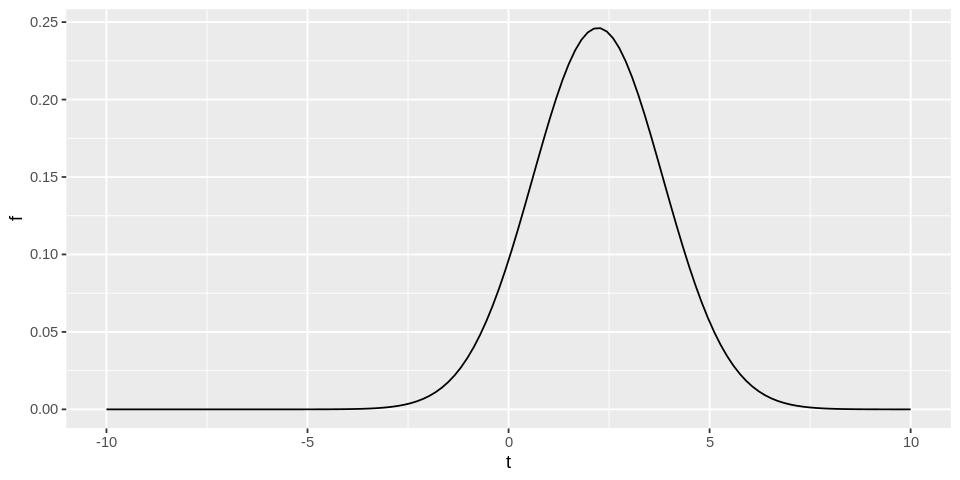

In [129]:
data.frame(
    t = seq(-10,10, length.out=128)
) %>%
    mutate(
        f = dnorm(t, mean=2.22, sd=1.62)
    ) %>%
ggplot() +
    geom_line(aes(t,f))

In [96]:
optim.lnorm = \(mu,sigma) optim(c(0,1), \(ps) {
    (mu - exp(ps[1] + ps[2]^2/2))^2 + (sigma - sqrt((exp(ps[2]^2)-1) * exp(2*ps[1]+ps[2]^2)))^2
})

In [103]:
optim.gamma = \(mu,sigma) optim(c(1,1), \(params) {
    k = params[1]
    theta = params[2]
    (mu - k*theta)^2 + (sigma - sqrt(k)*theta)^2
})

In [104]:
omic.lnorm = optim.lnorm(mu=4.0, sigma=3.7)
omic.gamma = optim.gamma(mu=4.0, sigma=3.7)
del.lnorm = optim.lnorm(mu=8.8, sigma=19)
del.gamma = optim.gamma(mu=8.8, sigma=19)

In [114]:
samples =  rgamma(1024, shape=del.gamma$par[1], scale=del.gamma$par[2])
c(mean(samples), sd(samples))

[1]  9.266686 19.253598

Warning message:
“Transformation introduced infinite values in continuous y-axis”


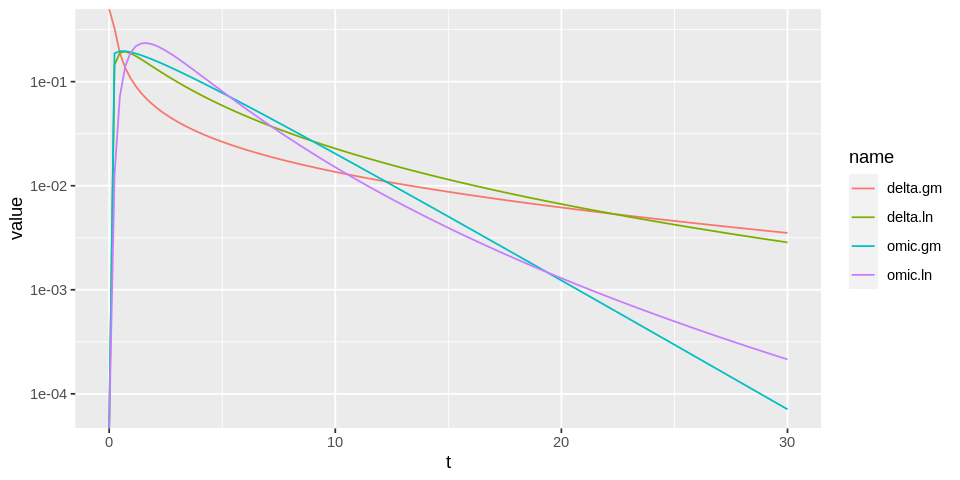

In [119]:
data.frame(
    t = seq(0,30, length.out = 128)
) %>%
    mutate(
        delta.ln = dlnorm(t, meanlog=del.lnorm$par[1], sdlog=del.lnorm$par[2]),
        omic.ln = dlnorm(t, meanlog=omic.lnorm$par[1], sdlog=omic.lnorm$par[2]),
        delta.gm = dgamma(t, shape=del.gamma$par[1], scale=del.gamma$par[2]),
        omic.gm = dgamma(t, shape=omic.gamma$par[1], scale=omic.gamma$par[2])
    ) %>%
    pivot_longer(-t) %>%
ggplot() +
    geom_line(aes(t, value, color=name)) -> g

fig(8,4)
g + 
    scale_y_continuous(trans=scales::log10_trans())

$$
\def\RR{{\rm RR}}
\def\P{{\rm P}}
\def\odds{{\rm odds}}
\begin{align}
\RR(death|omic,adm)
& = \frac{\odds(omic|death,adm)}{\odds(omic|adm)}
\end{align}$$

$$
\def\intii#1{{\int_{-\infty}^\infty #1}}
f(t) = \intii{g(s) h(t \pm s) \,ds}
$$

$$
\def\E{{\bf E}}
\begin{align}
\E_f[t] 
& = \intii{t f(t) \,dt} \\
& = \intii{t \intii{g(s) h(t \pm s) \,ds} \,dt} \\
& = \intii{g(s) \intii{t h(t \pm s) \,dt} \,ds} \\
& = \intii{g(s) \intii{(u \mp t) h(u) \,du} \,ds} & t \pm s=u\\
& = \intii{g(s) \left\{ \E_h[t] \mp \intii{sh(u)\,du} \right\} \,ds} \\
& = \E_h[t] \mp \intii{ \intii{s g(s)\,ds} h(u) \,du} \\
& = \E_h[t] \mp \E_g[t]
\end{align}$$

$$
\begin{align}
\E_f[t^2] 
& = \intii{t^2 f(t)\,dt} \\
& = \intii{t^2 \intii{g(s) h(t \pm s)\,ds}\,dt} \\
& = \intii{g(s) \intii{t^2 h(t \pm s)\,dt}\,ds} \\
& = \intii{g(s) \intii{(u^2+s^2 \mp 2us) h(u)\,du}\,ds} & t \pm s=u\\
& = \E_h[t^2] + \E_g[t^2] \mp 2\intii{\intii{uh(u)\,du}\ sg(s)\,ds}\\
& = \E_h[t^2] + \E_g[t^2] \mp 2\E_h[t]\E_g[t]\\
\end{align}$$

$$
\def\V{{\bf V}}
\begin{align}
\V_f[t] 
& = \E_f[t^2] - \E^2_f[t] \\
& = \E_h[t^2]+\E_g[t^2] \mp 2\E_h[t]\E_g[t] - (\E_h[t] \mp \E_g[t])^2 \\
& = \E_h[t^2] - \E^2_h[t] + \E_g[t^2] - \E^2_g[t] \\
& = \V_h[t] + \V_g[t]
\end{align}$$

$$\begin{align}
f(t)
& = \int h(s) h(u) g(v)\ ds\ du & s+t=v+u \\
& = \int h(s) h(u) g(t+s-u)\ ds\ du \\
& = \int h(s) \left\{ \int h(u) g(t+s-u) \ du\right\}\ ds \\
\end{align}$$

$$\begin{align}
\E_f[t] 
& = \intii{t h(s) h(t+s)\ ds}
\end{align}$$

$$t^{1,2}_i \to t^{1,2}_o \sim h(t^{1,2}_o - t^{1,2}_i)$$

$$t^1_i \to t^2_i \sim g(t^2_i - t^1_i)$$

$$t^1_o \to t^2_o \sim f(t^2_o - t^1_o)$$

$$t^1_i \to t^1_o , t^1_i \to t^2_i \to t^2_o$$

$$\begin{align}
[g/h](t)
& := \int_{s-u=t} g(s) h(u) ds \\
& = \int g(s) h(s-t) ds \\
& = \int g(s+t) h(s) ds
\end{align}$$

$$\begin{align}
[f*[g \star h]](t) 
& = \int f(t-s) [g/h](s) ds \\
& = \int f(t-s) \left( \int g(u+s) h(u) du \right) ds \\
& = \int \left(\int f(t-s) g(u+s) \ ds \right) h(u)\ du\\
& = \int \left(\int f(v) g(u+t-v) \ dv \right) h(u)\ du & t-s=v\\
& = \int [f*g](u+t)\ h(u)\ du \\
& = [[f*g]\star h]]
\end{align}$$

$$\begin{align}
f(t)
& = [[h*g] \star h](t) \\
& = [g*[h \star h]](t) \\
& = \int g(t-s)\ [h \star h](s)\ ds \\
& = \int g(t-s) \left( \int h(u+s)\ h(u) \ du \right)\ ds
\end{align}$$

$\def\E{{\rm E}}$

$y = z y_1 + (1-z) y_0$

$$\begin{align}
p(y_1, y_0, z, x)
& = p(y_1,y_0 | z,x) p(z|x) p(x) \\
& = p(y_1,y_0 | x) p(z|x) p(x) & y_i \perp z | x \Leftrightarrow p(y_i|z,x) = p(y_i|x) \\
\end{align}$$

$\E_(y_i) = \int y_i p(x) \ dx$

$\E(y_1) - \E(y_0)$

$$\begin{align}
\E(y_i|z=i,x)
& = \int y_i p(y_i|z=i,x)\ dx \\
& = \int y_i p(y_i|x)\ dx && y_i \perp z|x \\
& = \E(y_i|x)
\end{align}$$

median/mean is $\exp(\mu+\sigma^2/2) / \exp(\mu) = \exp(\sigma^2/2)$

In [1]:
require(cmdstanr)

Loading required package: cmdstanr

This is cmdstanr version 0.4.0

- Online documentation and vignettes at mc-stan.org/cmdstanr

- CmdStan path set to: /opt/conda/bin/cmdstan

- Use set_cmdstan_path() to change the path



Generation density $g(s,u)$ counts generations with infector infected at time $s$ and infectee infected at time $u$.
Then forward and backward generation interval density $f_t(\tau)$ and $b_t(\tau)$ are defined as follows respectively:
$$\begin{align}
f_t(\tau) \sim g(t,t+\tau) ,\\
b_t(\tau) \sim g(t-\tau,t) .
\end{align}$$
And corresponding density distributions as follows:
$$
\def\intii{\int_{-\infty}^\infty}
\begin{align}
f(\tau) \sim \intii g(t,t+\tau) dt , \\
b(\tau) \sim \intii g(t-\tau,t) dt .
\end{align}$$

$C(p,s)$ counts the number of records whose primary event time $p$ and secondary event time $s$. 

Primary cohort $P(p)$ at time $p$ can be expressed by $C(p,s)$ as $P(p) = \int C(p,s) ds$, and secondary cohort $S(s)$ as $S(s) = \int C(p,s) dp$.

We can express the forward interval density distribution $f_t(\tau)$ at time $t$ as
$$\begin{align}
f_t(\tau)
& = \frac{C(t,t+\tau)}{\int C(t,t+\tau) d\tau} \\
& = \frac{C(t,t+\tau)}{P(t)} 
\end{align}$$
and backward distribution $b_t(\tau)$ as
$$
b_t(\tau) = \frac{C(t-\tau,t)}{S(t)}.
$$

Now forward and backward distribution satisfies 
$$\begin{align}
P(t) f_t(\tau) = S(t+\tau) b_{t+\tau}(\tau) \\
P(t-\tau) f_{t-\tau}(\tau) = S(t) b_t(\tau) \\
\end{align}$$

If we want to estimate a incubation period distribution from observed data,
primary event is infection of a person and secondary is symptom onset of the same person.
Then primary cohort $P(t)$ represents the number of infections at time t,
and secondary cohort $S(t)$ of onset.

If we assume that primary cohort $P(t)$ exponentially grows($P(t) = P(0) \exp(rt)$) with growth rate $r$ and that forward incubation period distribution $f_t(\tau)$ is consistent over time($f_t(\tau) = f(\tau)$), above forward-backward relation becomes
$$
P(t) \exp(-r\tau) f(\tau) = S(t) b_t(\tau)
$$
and backward incubation period distribution $b_t(\tau)$ is
$$
b_t(\tau) = b(\tau) = \frac{\exp(-r\tau) f(\tau)}{\int \exp(-r \tau) f(\tau) d\tau}.
$$

$$\begin{align}
{\rm hazard\ ratio}
& = ( N(!vax|hosp) / N(!vax) ) / ( N(vax|hosp) / N(vax) ) \\
& = ( N(!vax|hosp) / N(vax|hosp) ) / ( N(!vax) / N(vax) ) \\
& = {\rm odds}(!vax|hosp) / odds(!vax) \\
& = {\rm RR}(hosp|!vax)
\end{align}$$

In [3]:
model = cmdstan_model(write_stan_file('
data {
    real incubation_lnorm_mu;
    real incubation_lnorm_sd;
}
parameters {
    
}
'))

In [6]:
meanlog = log(4.2)
sdlog = sqrt(2*log(4.2/3))

In [14]:
fig = \(width, height) options(repr.plot.width=width, repr.plot.height=height)

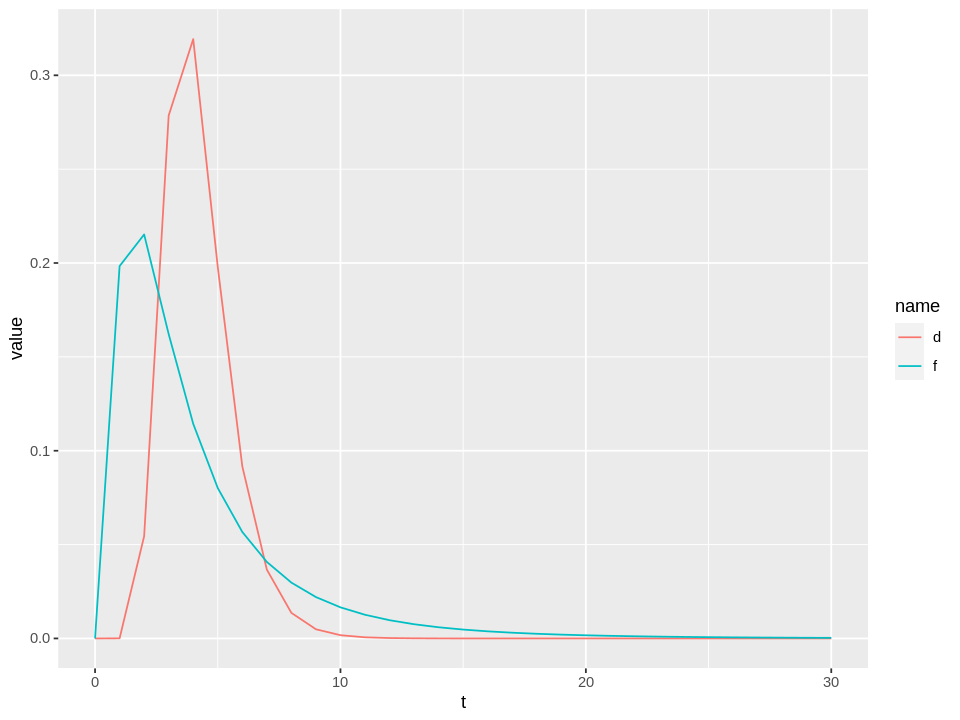

In [28]:
t = seq(0,30)
f = dlnorm(t, meanlog=log(3), sdlog = sqrt(2*log(4.2/3)))
d = dlnorm(t, meanlog=log(4), sdlog = sqrt(2*log(4.2/4)))

fig(8,6)
data.frame(
    t = t,
    f = f,
    d = d
) %>%
    pivot_longer(-t) %>%
ggplot() +
    geom_line(aes(t, value, color=name))

In [3]:
require(tidyverse)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

